In [3]:
%%capture
from pathlib import Path

if Path.cwd().stem == "notebooks":
    %cd ..
    %load_ext autoreload
    %autoreload 2

In [4]:
import logging
from pathlib import Path

import holoviews as hv
import hvplot.polars  # noqa  # noqa
import numpy as np
import polars as pl
from matplotlib import pyplot as plt
from polars import col

from src.data.database_manager import DatabaseManager
from src.features.exploratory.explore_eda import detrend_tonic_component
from src.features.scaling import scale_min_max
from src.log_config import configure_logging
from src.plots.correlations import (
    aggregate_correlations_fisher_z,
    calculate_correlations_by_trial,
    plot_correlations_by_participant,
    plot_correlations_by_trial,
    plot_max_correlations_by_participant,
)

logger = logging.getLogger(__name__.rsplit(".", maxsplit=1)[-1])
configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado", "param", "numba"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

logger = logging.getLogger(__name__.rsplit(".", maxsplit=1)[-1])
configure_logging(
    stream_level=logging.DEBUG,
    ignore_libs=["matplotlib", "Comm", "bokeh", "tornado", "param", "numba"],
)

pl.Config.set_tbl_rows(12)  # for the 12 trials
hv.output(widget_location="bottom", size=130)

In [5]:
db = DatabaseManager()
with db:
    df = db.get_trials("Explore_Data", exclude_problematic=True)

# Rename columns
df = df.rename(
    {
        "rating": "pain_rating",
    }
)

# Remove first 20 seconds
df = df.filter(col("normalized_timestamp") >= 20 * 1000)
df

shape: (754_071, 33)
┌──────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ trial_id ┆ trial_num ┆ participa ┆ timestamp ┆ … ┆ strictly_ ┆ strictly_ ┆ plateau_i ┆ prolonged │
│ ---      ┆ ber       ┆ nt_id     ┆ ---       ┆   ┆ increasin ┆ increasin ┆ ntervals  ┆ _minima_i │
│ u16      ┆ ---       ┆ ---       ┆ f64       ┆   ┆ g_interva ┆ g_interva ┆ ---       ┆ ntervals  │
│          ┆ u8        ┆ u8        ┆           ┆   ┆ ls        ┆ ls_…      ┆ u16       ┆ ---       │
│          ┆           ┆           ┆           ┆   ┆ ---       ┆ ---       ┆           ┆ u16       │
│          ┆           ┆           ┆           ┆   ┆ u16       ┆ u16       ┆           ┆           │
╞══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1        ┆ 1         ┆ 1         ┆ 220180.93 ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0         │
│          ┆           ┆           ┆ 48        ┆   ┆           ┆           ┆           ┆           │
│ 1        ┆ 1         ┆ 1         ┆ 220280.93 ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0         │
│          ┆           ┆           ┆ 48        ┆   ┆           ┆           ┆           ┆           │
│ 1        ┆ 1         ┆ 1         ┆ 220380.93 ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0         │
│          ┆           ┆           ┆ 48        ┆   ┆           ┆           ┆           ┆           │
│ 1        ┆ 1         ┆ 1         ┆ 220480.93 ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0         │
│          ┆           ┆           ┆ 48        ┆   ┆           ┆           ┆           ┆           │
│ 1        ┆ 1         ┆ 1         ┆ 220580.93 ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0         │
│          ┆           ┆           ┆ 48        ┆   ┆           ┆           ┆           ┆           │
│ 1        ┆ 1         ┆ 1         ┆ 220680.93 ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0         │
│          ┆           ┆           ┆ 48        ┆   ┆           ┆           ┆           ┆           │
│ …        ┆ …         ┆ …         ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 496      ┆ 4         ┆ 42        ┆ 1.1405e6  ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0         │
│ 496      ┆ 4         ┆ 42        ┆ 1.1406e6  ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0         │
│ 496      ┆ 4         ┆ 42        ┆ 1.1407e6  ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0         │
│ 496      ┆ 4         ┆ 42        ┆ 1.1408e6  ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0         │
│ 496      ┆ 4         ┆ 42        ┆ 1.1409e6  ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0         │
│ 496      ┆ 4         ┆ 42        ┆ 1.1410e6  ┆ … ┆ 0         ┆ 0         ┆ 0         ┆ 0         │
└──────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

# Temperature

In [12]:
referece = "temperature"
targets = [
    "brow_furrow",
    "cheek_raise",
    "mouth_open",
    "upper_lip_raise",
    "nose_wrinkle",
]

corr_by_trial = calculate_correlations_by_trial(df, referece, targets)

In [13]:
corr_by_trial.describe()

shape: (9, 11)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ statistic ┆ trial_id  ┆ trial_num ┆ participa ┆ … ┆ temperatu ┆ temperatu ┆ temperatu ┆ temperat │
│ ---       ┆ ---       ┆ ber       ┆ nt_id     ┆   ┆ re_cheek_ ┆ re_mouth_ ┆ re_upper_ ┆ ure_nose │
│ str       ┆ f64       ┆ ---       ┆ ---       ┆   ┆ raise_cor ┆ open_corr ┆ lip_raise ┆ _wrinkle │
│           ┆           ┆ f64       ┆ f64       ┆   ┆ r         ┆ ---       ┆ _co…      ┆ _corr    │
│           ┆           ┆           ┆           ┆   ┆ ---       ┆ f64       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆ f64       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ count     ┆ 471.0     ┆ 471.0     ┆ 471.0     ┆ … ┆ 471.0     ┆ 471.0     ┆ 471.0     ┆ 471.0    │
│ null_coun ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ … ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0      │
│ t         ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ mean      ┆ 244.05095 ┆ 6.369427  ┆ 20.806794 ┆ … ┆ 0.08013   ┆ 0.060322  ┆ 0.065341  ┆ 0.133753 │
│           ┆ 5         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ std       ┆ 144.84621 ┆ 3.453558  ┆ 12.078944 ┆ … ┆ 0.264647  ┆ 0.24307   ┆ 0.221986  ┆ 0.266347 │
│           ┆ 9         ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ min       ┆ 1.0       ┆ 1.0       ┆ 1.0       ┆ … ┆ -0.623594 ┆ -0.602409 ┆ -0.572551 ┆ -0.70207 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 1        │
│ 25%       ┆ 119.0     ┆ 3.0       ┆ 10.0      ┆ … ┆ -0.10611  ┆ -0.109736 ┆ -0.101008 ┆ -0.05195 │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ 2        │
│ 50%       ┆ 237.0     ┆ 6.0       ┆ 20.0      ┆ … ┆ 0.089317  ┆ 0.063752  ┆ 0.062246  ┆ 0.162263 │
│ 75%       ┆ 373.0     ┆ 9.0       ┆ 32.0      ┆ … ┆ 0.274068  ┆ 0.225938  ┆ 0.229693  ┆ 0.330962 │
│ max       ┆ 496.0     ┆ 12.0      ┆ 42.0      ┆ … ┆ 0.750349  ┆ 0.620446  ┆ 0.670945  ┆ 0.743935 │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

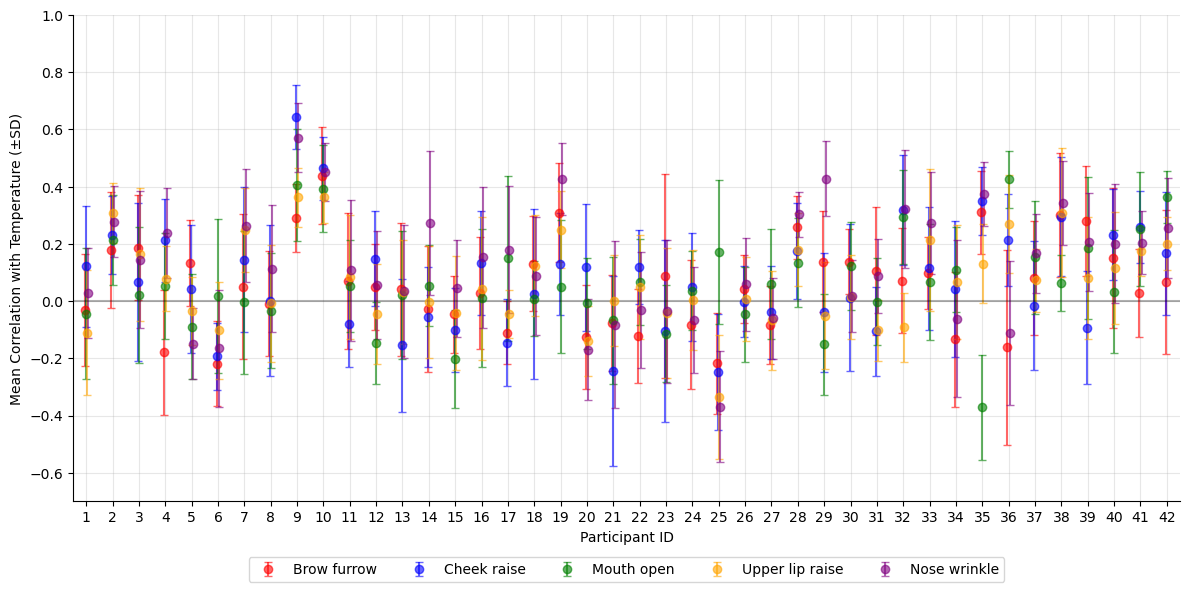

In [15]:
fig = plt.figure(figsize=(12, 6))

# Define the correlation columns and their display properties
correlation_columns = [
    "temperature_brow_furrow_corr",
    "temperature_cheek_raise_corr",
    "temperature_mouth_open_corr",
    "temperature_upper_lip_raise_corr",
    "temperature_nose_wrinkle_corr",
]

colors = ["red", "blue", "green", "orange", "purple"]
labels = ["Brow furrow", "Cheek raise", "Mouth open", "Upper lip raise", "Nose wrinkle"]

# Create dodge offsets
dodge_width = 0.1
n_signals = len(correlation_columns)
dodge_positions = np.linspace(-dodge_width / 2, dodge_width / 2, n_signals)

# Get participant IDs
participant_ids = corr_by_trial.get_column("participant_id").unique().sort().to_numpy()

# Plot each signal type directly from the original columns
for i, (col, color, label, dodge) in enumerate(
    zip(correlation_columns, colors, labels, dodge_positions)
):
    # Calculate mean and std for each participant directly
    participant_stats = (
        corr_by_trial.group_by("participant_id")
        .agg(
            [pl.col(col).mean().alias("mean_corr"), pl.col(col).std().alias("std_corr")]
        )
        .sort("participant_id")
    )

    # Extract values
    mean_corrs = participant_stats.get_column("mean_corr").to_numpy()
    std_corrs = participant_stats.get_column("std_corr").to_numpy()

    # Add dodge to participant IDs
    x_positions = participant_ids + dodge

    plt.errorbar(
        x_positions,
        mean_corrs,
        yerr=std_corrs,
        fmt="o",
        color=color,
        label=label,
        capsize=3,
        alpha=0.6,
        markersize=6,
    )

plt.xlabel("Participant ID")
plt.ylabel("Mean Correlation with Temperature (±SD)")
plt.xlim(participant_ids.min() - 0.5, participant_ids.max() + 0.5)
plt.ylim(-0.7, 1)
plt.legend(bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=5)
plt.axhline(y=0, color="black", linestyle="-", alpha=0.3)
plt.grid(True, alpha=0.3)
plt.xticks(participant_ids)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.show()

In [16]:
# Save figure
import os
from pathlib import Path

from dotenv import load_dotenv

load_dotenv()
FIGURE_DIR = Path(os.getenv("FIGURE_DIR"))


# Save the figure
path = FIGURE_DIR / "correlations_with_temperature_face.png"
fig.savefig(path)
